In [1]:
import h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import tables
import matplotlib.pyplot as plt
import tensorflow as tf
import preprocessing


In [2]:
dataPath = '/home/WindowsDrive/Shared/Top_Tagging_Data/test.h5'
batch_size = 100

In [3]:
with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'])

    npDataWeights = np.array(data['weights'])
    
    hlDataArr = {key: data[key][...] for key in data.attrs.get('hl')}


## Preprocessing

In [4]:
processed_dict = preprocessing.high_level(hlDataArr)
processed_df = pd.DataFrame(processed_dict)


In [5]:
data_1, data_test, labels_1, labels_test, weights_1, weights_test = train_test_split(processed_df, npDataLabels, npDataWeights, test_size=0.33, random_state=69, shuffle=True)

data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = train_test_split(data_1, labels_1, weights_1, test_size = 0.05, random_state=420, shuffle=True)

In [6]:
train_data_set = tf.data.Dataset.from_tensor_slices((data_train, labels_train, weights_train)).batch(batch_size)

valid_data_set = tf.data.Dataset.from_tensor_slices((data_valid, labels_valid, weights_valid)).batch(batch_size)

2022-10-01 19:34:46.420440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 19:34:46.426778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 19:34:46.426966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 19:34:46.427429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Training now

In [7]:
model = Sequential()
model.add(keras.Input(shape=data_train.shape[1:]))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', weighted_metrics=['accuracy', 'binary_accuracy'])   

In [8]:
history = model.fit(train_data_set, validation_data=valid_data_set, epochs=8, batch_size=batch_size, verbose=1)

Epoch 1/8
15812/15812 [==============================] - 54s 3ms/step - loss: 0.3731 - accuracy: 0.8312 - binary_accuracy: 0.8312 - val_loss: 0.3752 - val_accuracy: 0.8324 - val_binary_accuracy: 0.8324
Epoch 2/8
15812/15812 [==============================] - 54s 3ms/step - loss: 0.3593 - accuracy: 0.8392 - binary_accuracy: 0.8392 - val_loss: 0.3681 - val_accuracy: 0.8351 - val_binary_accuracy: 0.8351
Epoch 3/8
15812/15812 [==============================] - 54s 3ms/step - loss: 0.3559 - accuracy: 0.8410 - binary_accuracy: 0.8410 - val_loss: 0.3634 - val_accuracy: 0.8370 - val_binary_accuracy: 0.8370
Epoch 4/8
15812/15812 [==============================] - 54s 3ms/step - loss: 0.3538 - accuracy: 0.8421 - binary_accuracy: 0.8421 - val_loss: 0.3620 - val_accuracy: 0.8384 - val_binary_accuracy: 0.8384
Epoch 5/8
15812/15812 [==============================] - 55s 4ms/step - loss: 0.3523 - accuracy: 0.8429 - binary_accuracy: 0.8429 - val_loss: 0.3607 - val_accuracy: 0.8390 - val_binary_accurac

In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'binary_accuracy', 'val_loss', 'val_accuracy', 'val_binary_accuracy'])


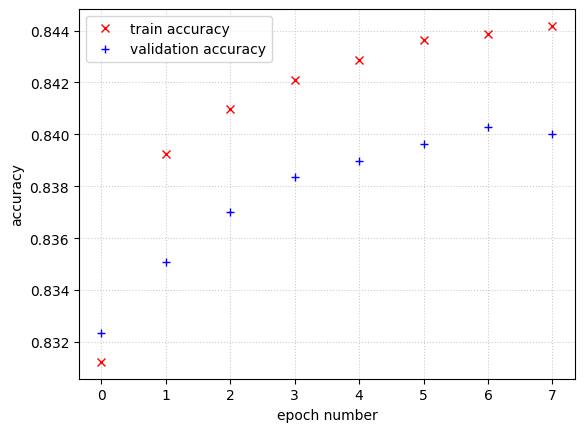

In [13]:
plt.figure()
plt.plot(history.history['accuracy'], 'rx', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'b+', label='validation accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.grid(color='#CCCCCC', linestyle=':')
plt.legend()
plt.savefig('Report/Plots/accuracy_history.pdf')
plt.show()


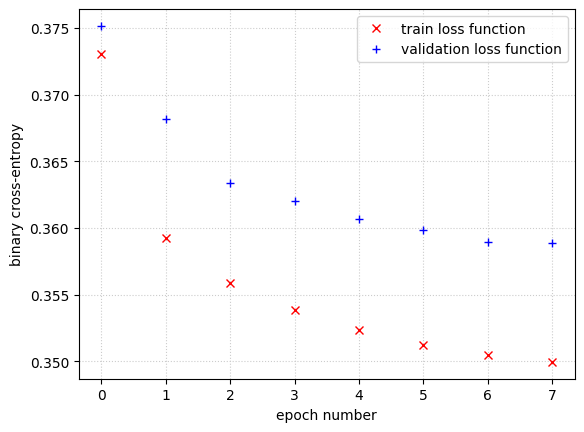

In [16]:
plt.figure()
plt.plot(history.history['loss'], 'rx', label='train loss function')
plt.plot(history.history['val_loss'], 'b+', label='validation loss function')
plt.xlabel('epoch number')
plt.ylabel('binary cross-entropy')
plt.grid(color='#CCCCCC', linestyle=':')
plt.legend()
plt.savefig('Report/Plots/loss_history.pdf')
plt.show()


In [19]:
pred_test = model.predict(data_test, verbose=1)

25618/25618 [==============================] - 30s 1ms/step


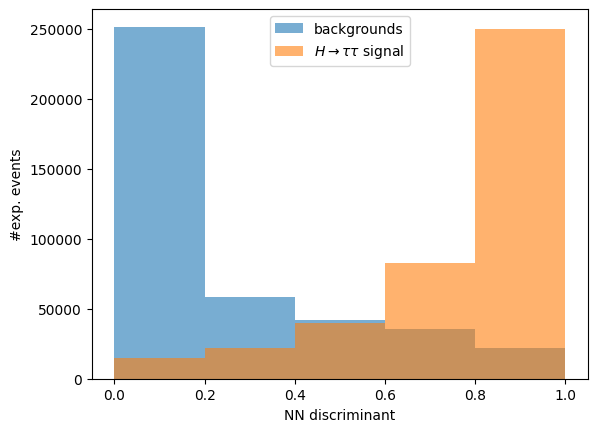

In [13]:
dfNN_test = pd.DataFrame()
dfNN_test["labels"] = labels_test
dfNN_test["predictions"] = pred_test
dfNN_test["weights"] = weights_test

signalVals = dfNN_test[dfNN_test['labels']== 1] 
backgroundVals = dfNN_test[dfNN_test['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

# bkgHistNN = plt.hist(backgroundVals['predictions'], bins=5, label="backgrounds", range=[0,1], alpha=0.6)
# sigHistNN = plt.hist(signalVals['predictions'], bins=5, label="signals", range=[0,1], alpha=0.6)

plt.legend()
# plt.yscale('log')
plt.show()

In [14]:
pred_train = model.predict(data_train)

52012/52012 [==============================] - 62s 1ms/step


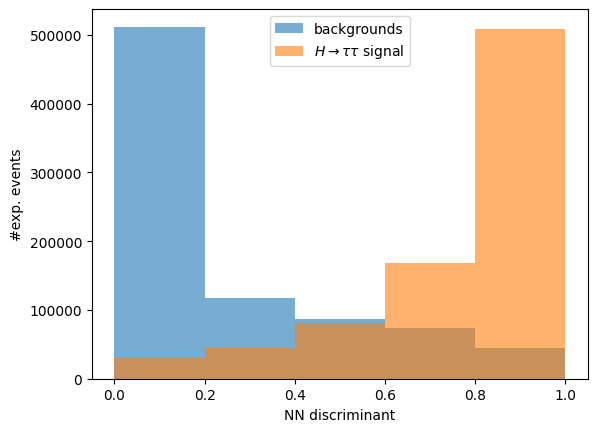

In [15]:
dfNN_train = pd.DataFrame()
dfNN_train["labels"] = labels_train
dfNN_train["predictions"] = pred_train
dfNN_train["weights"] = weights_train

signalVals = dfNN_train[dfNN_train['labels']== 1] 
backgroundVals = dfNN_train[dfNN_train['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

In [17]:
model.save('./models/final_model')

INFO:tensorflow:Assets written to: ./models/final_model/assets


In [20]:
print(len(labels_valid))

83218
